In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import arviz as az
import warnings
warnings.filterwarnings("ignore") 
import scipy.stats as st
from patsy import dmatrix, dmatrices

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 11.2 Data generation

In [2]:
np.random.seed(1234)
n_groups = 3
n_sample = 10
n = n_groups * n_sample                                               # Total number of data points
x = np.repeat(np.arange(1, n_groups+1), n_sample)                     # Indicator for population
pop = np.repeat(["Pyrenees", "Massif Central", "Jura"], n_sample)
length = st.uniform.rvs(45, 25, size = n)                             # Obs. body length (cm) is rarely less than 45

data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 'length': length})
Xmat = dmatrix("~ C(pop, Treatment('Pyrenees')) * length", data_ds, return_type = 'dataframe')

# Re-order columns to have the order as in the book
Xmat = Xmat[['Intercept',
 "C(pop, Treatment('Pyrenees'))[T.Massif Central]",
 "C(pop, Treatment('Pyrenees'))[T.Jura]",
 'length',
 "C(pop, Treatment('Pyrenees'))[T.Massif Central]:length",
 "C(pop, Treatment('Pyrenees'))[T.Jura]:length"]].to_numpy()
beta_vec = [-250, 150, 200, 6, -3, -4]

lin_pred = Xmat @ beta_vec
eps = st.norm.rvs(0, 10, size = n)
mass = lin_pred + eps
data = pd.DataFrame({'mass': mass, 'pop': pd.Series(pop, dtype = 'category'), 'length': length})

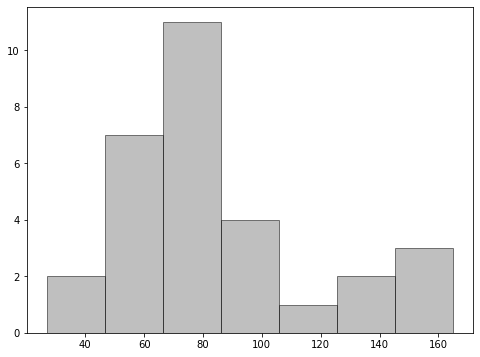

In [3]:
plt.figure(figsize = (8, 6))
plt.hist(mass, bins = 7, color= 'gray', edgecolor='black', alpha = 0.5);

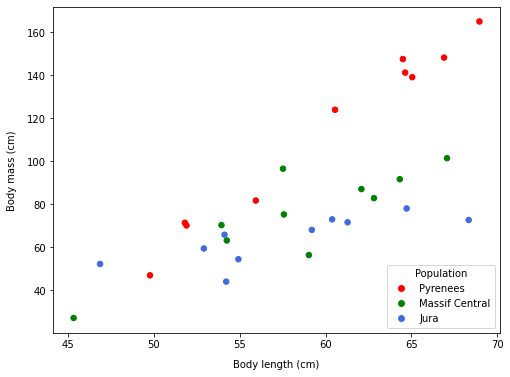

In [4]:
plt.figure(figsize = (8, 6))
colors = {"Pyrenees": 'red', "Massif Central": 'green', "Jura": 'royalblue'}
plt.scatter(data['length'], data['mass'], marker='o', s=30, linewidths=1, c=data['pop'].map(colors))
plt.xlabel('Body length (cm)', fontsize = 10, labelpad = 10)
plt.ylabel('Body mass (cm)', fontsize = 10, labelpad = 10)
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='Population', handles=handles, loc='lower right');

### 11.3 Analysis using MLE wit *statsmodels*

In [5]:
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

In [6]:
data['length_scaled'] = (data['length'] - data['length'].mean()) / data['length'].std()

In [7]:
mod = ols(formula = "mass ~ C(pop, Treatment('Pyrenees'))*length_scaled", data=data)
res = mod.fit()
print(res.params)

Intercept                                                        105.855930
C(pop, Treatment('Pyrenees'))[T.Jura]                            -40.602982
C(pop, Treatment('Pyrenees'))[T.Massif Central]                  -29.807965
length_scaled                                                     37.377690
C(pop, Treatment('Pyrenees'))[T.Jura]:length_scaled              -28.654399
C(pop, Treatment('Pyrenees'))[T.Massif Central]:length_scaled    -17.951247
dtype: float64


### 11.4 Analysis using PyMC3

In [8]:
idx = pd.factorize(pop)[0]
groups = len(np.unique(idx))

In [9]:
with pm.Model() as model_11_4:
    
    alpha = pm.Normal('alpha', 0, tau = 0.001, shape = groups)
    beta = pm.Normal('beta', 0, tau = 0.001, shape = groups)
    sigma = pm.Uniform('sigma', 0, 100)
    mu = pm.Deterministic('mu', alpha[idx] + beta[idx] * data['length_scaled'])
    mass_pred = pm.Normal('mass_pred', mu, sigma, observed = data['mass'])
    # Define effects relative to baseline level
    a_effe2 = pm.Deterministic('a_effect2', alpha[1] - alpha[0])           # Intercept Massif Central vs. Pyr.
    a_effe3 = pm.Deterministic('a_effect3', alpha[2] - alpha[0])           # Intercept Jura vs. Pyr.
    b_effe2 = pm.Deterministic('b_effect2', beta[1] - beta[0])             # Slope Massif Central vs. Pyr.
    b_effe3 = pm.Deterministic('b_effect3', beta[2] - beta[0])             # Slope Jura vs. Pyr.
    
    # Custom tests
    test1 = pm.Deterministic('test1', beta[2] - beta[1])             # Slope Jura vs. Massif Central
    trace_11_4 = pm.sample(5000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 29 seconds.


In [10]:
az.summary(trace_11_4, var_names = ['~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],104.932,3.139,99.053,110.834,0.029,0.021,11381.0,7479.0,1.0
alpha[1],75.335,3.009,69.888,81.055,0.029,0.021,10737.0,7154.0,1.0
alpha[2],64.620,3.101,58.513,70.150,0.029,0.021,11166.0,7626.0,1.0
beta[0],37.236,2.931,31.557,42.637,0.029,0.020,10528.0,7222.0,1.0
beta[1],19.205,3.289,12.975,25.267,0.028,0.020,13457.0,7816.0,1.0
beta[2],8.538,3.282,2.240,14.626,0.031,0.022,11403.0,7946.0,1.0
sigma,9.522,1.499,7.027,12.467,0.017,0.012,7774.0,6891.0,1.0
a_effect2,-29.597,4.278,-38.029,-21.856,0.041,0.029,10918.0,7350.0,1.0
a_effect3,-40.312,4.363,-48.449,-32.015,0.042,0.030,10945.0,7604.0,1.0
b_effect2,-18.031,4.475,-26.526,-9.626,0.042,0.030,11585.0,6980.0,1.0
